* 模型选择、欠拟合、过拟合

**K折交叉验证**

将数据集分层采样划分为k个大小相似的互斥子集，每次用k-1个子集的并集作为训练集，余下的子集作为测试集，最终返回k个测试结果的均值，k最常用的取值是10

**手动实现K折交叉验证**

创建数据集

In [1]:
import numpy as np
import random
import torch

X = torch.rand(100, 32, 32)
Y = torch.rand(100, 1)

index = [i for i in range(len(X))]
random.shuffle(index)
X = X[index]
Y = Y[index]

获取k折交叉验证某一折的训练集和验证集

In [2]:
def get_kfold_data(k, i, X, y):
    fold_size = X.shape[0]//k
    val_start = i * fold_size
    if i  != k - 1:
        val_end = (i + 1) * fold_size
        X_valid, y_valid = X[val_start:val_end],y[val_start:val_end]
        X_train = torch.cat((X[0:val_start],X[val_end:]),dim=0)
        y_train = torch.cat((y[0:val_start],y[val_end:]),dim=0)
    else:
        X_valid,y_valid = X[val_start:], y[val_start:]
        X_train = X[0:val_start]
        y_train = y[0:val_start]
    
    return X_train, y_trian, X_valid, y_valid
        

依次对每一折数据进行训练和测试，并计算k折平均值

In [3]:
def k_fold(k, X_train, y_train):
    
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum, valid_acc_sum = 0, 0
    
    for i in range(k):
        print('第', i+1, '折验证结果')
        data = get_kfold_data(k, i, X_train, y_train)
        net = Net()
        train_loss, val_loss, train_acc, val_acc = train(net, *data)
        
        train_loss_sum += train_loss
        valid_loss_sum += val_loss
        train_acc_sum += train_acc
        valid_acc_sum += val_acc
    
    print('\n','最终k折交叉验证结果')
    
    print('average train loss:{:.4f}, average train accuracy:{:.3f}%'.format(train_loss_sum/k, train_acc_sum/k))
    print('average valid loss:{:.4f}, average valid accuracy:{:.3f}%'.format(valid_loss_sum/k, valid_acc_sum/k))
    
    return

**给定样本特征，使用如下的三阶多项式函数来生成样本的标签**    
y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + e

设置噪声项e服从均值为0、标准差为0.1的正态分布。训练数据集和测试数据集的样本数都设为100

In [4]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)),1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
         + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype=torch.float)
print(features[0],labels[0])

tensor([-0.0545]) tensor(4.9260)


定义作图函数Draw_Loss_Curve

In [5]:
import matplotlib.pyplot as plt
def Draw_Loss_Curve(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
                    legend=None, figsize=(3.5, 2.5)):
#     display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

模型定义和训练函数定义

In [6]:
num_epochs, loss = 100, torch.nn.MSELoss()
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    #训练模型
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    Draw_Loss_Curve(range(1,num_epochs +1), train_ls, 'epochs', 'loss',
                    range(1,num_epochs +1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
         '\nbias:',net.bias.data)

**使用三阶多项式函数拟合**

使用与数据生成函数同阶的三阶多项式函数拟合，学习到的模型参数接近真实值

final epoch: train loss 9.373664215672761e-05 test loss 9.724379196995869e-05
weight: tensor([[ 1.2009, -3.4004,  5.6004]]) 
bias: tensor([4.9978])


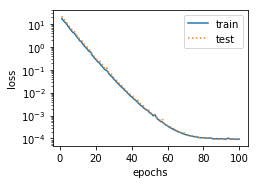

In [7]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

**使用线性函数拟合（欠拟合）**

将模型复杂度降低：使用线性函数。训练集和测试集的loss在后期均很难下降，出现欠拟合

final epoch: train loss 148.76889038085938 test loss 304.1312561035156
weight: tensor([[17.3630]]) 
bias: tensor([2.5815])


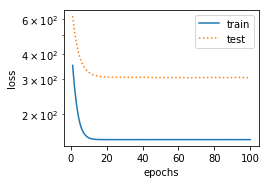

In [8]:
fit_and_plot(features[:n_train,:], features[n_train:,:],labels[:n_train],
            labels[n_train:])

**训练样本过少（过拟合）**

只使用两个样本来训练模型，训练集loss持续下降，测试集loss上升，出现过拟合

final epoch: train loss 0.7213004231452942 test loss 351.2501525878906
weight: tensor([[1.2290, 2.0520, 1.6240]]) 
bias: tensor([3.8054])


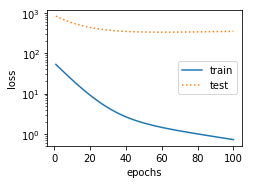

In [9]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
            labels[n_train:])

* 过拟合问题的常用方法——L2范数正则化

**以高斯线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合**

生成数据集

In [10]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import data
import numpy as np
import sys
sys.path.append('..')
from matplotlib import pyplot as plt
from IPython import display

In [11]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
# 生成数据集
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype = torch.float)
train_features, test_features = features[:n_train,:], features[n_train:,:]
train_labels, test_labels = labels[:n_train], labels[n_train:]
print(train_features[0][:5])
print(train_labels[0])

tensor([-0.4936, -0.4373,  0.0500,  0.8556, -0.9246])
tensor([-0.0125])


**手动实现L2范数正则化**

定义随机初始化模型参数的函数

In [12]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w,b

定义L2范数惩罚项

In [13]:
def l2_penalty(w):
    return (w**2).sum() / 2

定义模型

In [14]:
def linear(X, w, b):
    return torch.mm(X, w) + b

定义均方误差

In [15]:
def squared_loss(y_hat, y):
    return ((y_hat - y.view(y_hat.size()))**2)/2

定义随机梯度下降函数

In [16]:
def SGD(params, lr):
    for param in params:
        param.data -= lr*param.grad    

定义训练函数

In [17]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linear, squared_loss
#划分数据集
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
#训练模型
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X , y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            SGD([w, b], lr)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    Draw_Loss_Curve(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                   range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

lambd = 0（即不使用L2范数正则化）时的实验结果，出现了过拟合的现象。

L2 norm of w: 13.319792747497559


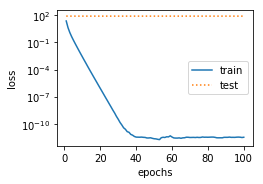

In [18]:
fit_and_plot(lambd=0)

lambd = 3（即使用L2范数正则化）时的实验结果，一定程度的缓解了过拟合。同时可以看到参数L2范数变小，参数更接近0.

L2 norm of w: 0.037893280386924744


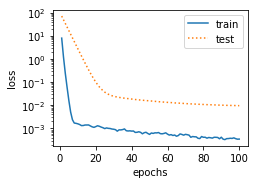

In [19]:
fit_and_plot(lambd=3)

**利用torch.optim的weight_decay参数实现L2范数正则化**

定义训练函数

In [20]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    
    optimizer_w = torch.optim.SGD(params = [net.weight],lr=lr,weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias],lr=lr)
    
    train_ls ,test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    Draw_Loss_Curve(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                   range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

lambd = 0 （即不使用L2范数正则化）时的实验结果，出现了过拟合的现象。

L2 norm of w: 13.032184600830078


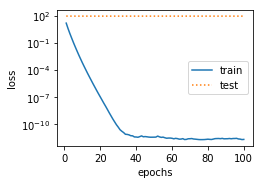

In [21]:
fit_and_plot_pytorch(0)

lambd = 3（即使用L2范数正则化）时的实验结果，一定程度的缓解了过拟合。同时可以看到参数L2范数变小，参数更接近0。

L2 norm of w: 0.056585632264614105


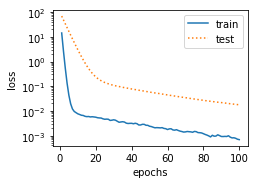

In [22]:
fit_and_plot_pytorch(3)

* 过拟合问题的常用方法——Dropout

**手动实现dropout**

设丢弃概率为p，那么有p的概率hi会被清零，有1-p的概率hi会除以1-p做拉伸。由此定义进行dropout操作的函数

In [23]:
def dropout(X, drop_prob):
    X = X.float()
    
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    return mask * X / keep_prob

初始化一个向量X，对X进行dropout，分别设置丢弃率为0、0.5、1，实验结果如下：

In [24]:
X = torch.arange(10).view(2,5)
print(dropout(X, 0),'\n')
print(dropout(X, 0.5),'\n')
print(dropout(X, 1),'\n')

tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]]) 

tensor([[ 0.,  0.,  4.,  0.,  8.],
        [ 0.,  0., 14.,  0.,  0.]]) 

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]) 



定义模型参数（使用Fashion-MNIST数据集进行实验)

In [25]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype= torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype = torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

定义使用dropout的网络模型，两个隐藏层的丢弃率分别为0.2和0.5

In [26]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:
        H1 = dropout(H1, drop_prob1)
    H2 = (torch.matmul(H1,W2) + b2).relu()
    if is_training:
        H2 = dropout(H2,drop_prob2)
    return torch.matmul(H2,W3)+b3

定义计算准确率的函数

In [40]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X, is_training=False).argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn

mnist_train = torchvision.datasets.FashionMNIST(root='~\Datasets\FashionMNIST',train=True,download=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~\Datasets\FashionMNIST',train=False,download=True,transform=transforms.ToTensor())

batch_size = 64
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size = batch_size,shuffle = True,num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=0)

def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params = None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X, is_training=True)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train_acc %.3f, test_acc %.3f'
              %(epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc))

In [41]:
num_epochs, lr, batch_size = 5, 0.1, 128
loss = torch.nn.CrossEntropyLoss()
train(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr, None)

epoch 1, loss 0.0071, train_acc 0.839, test_acc 0.824
epoch 2, loss 0.0065, train_acc 0.851, test_acc 0.854
epoch 3, loss 0.0061, train_acc 0.860, test_acc 0.822
epoch 4, loss 0.0059, train_acc 0.865, test_acc 0.856
epoch 5, loss 0.0056, train_acc 0.871, test_acc 0.866


**利用torch.nn.Dropout层实现dropout**

定义模型

In [42]:
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [47]:
net_pytorch = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10))

for param in net_pytorch.parameters():
    nn.init.normal_(param,mean=0, std= 0.01)

定义计算准确率的函数（eval（）和train（）来切换模型的状态）

In [48]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim =1) ==y).float().sum().item()
            net.train()
        n += y.shape[0]
    return acc_sum / n

In [50]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params = None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train_acc %.3f, test_acc %.3f'
              %(epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc))

In [51]:
optimizer = torch.optim.SGD(net_pytorch.parameters(),lr=0.1)
train(net_pytorch, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0158, train_acc 0.619, test_acc 0.742
epoch 2, loss 0.0082, train_acc 0.813, test_acc 0.796
epoch 3, loss 0.0071, train_acc 0.838, test_acc 0.825
epoch 4, loss 0.0065, train_acc 0.852, test_acc 0.851
epoch 5, loss 0.0061, train_acc 0.860, test_acc 0.855
